# Baseline Model training for Contrails image segmentation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import time
import pickle
import os

import tensorflow as tf
from tensorflow import keras

# Converts categorical integers to one hot encoding 0 and 1
from keras.utils import to_categorical

# Import necessary keras libraries for UNET
from keras.models import Model, load_model
from keras.applications import ResNet50
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, concatenate, BatchNormalization, Dropout, Lambda
from keras.layers import Flatten, LayerNormalization, Activation, MultiHeadAttention, Add, Dense, Reshape, RepeatVector, AveragePooling2D
from keras import losses
from keras import backend as K
# backend is tensor flow. At tensor level calculation, Keras does not cover it. Keras is only the framework. All backend methods are referred as K


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
tf.keras.backend.clear_session()

import multiprocessing


2023-07-12 02:05:14.614012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-12 02:05:14.614074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-12 02:05:14.614095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-12 02:05:14.625826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Segmentation Models: using `tf.keras` framework.


In [3]:
# Basline variables
BATCH_SIZE = 32
total_classes = 2
IMAGE_CHANNELS = 3
# Hyper Parameters
NUM_EPOCHS = 50

BASE_DIR = "../kaggle-files/kaggle-contrails/contrails-kaggle-files/"
TRAIN_DIR = BASE_DIR + "train/"
VALIDATION_DIR = BASE_DIR + "validation/"
TEST_DIR = BASE_DIR + "test/"
validation_ids = os.listdir(VALIDATION_DIR)
test_ids = os.listdir(TEST_DIR)
MODELS_PATH = "./models/"
TRAIN_HISTORY_PATH = MODELS_PATH + "train_history/"

In [29]:
# Helper Functions

# Variables used to normalize and build Ash images 
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

class DataGenerator(keras.utils.Sequence):
    """ 
    This is a Keras Data generator used to load the images in batches for training.
    The Kaggle flag is used to build the ash images at runtime, instead of loading pre-built images from disk
    The time_series flag is used to pass the 8 time-series images from the ash image instead of only getting the 5th time-series image [...,4]
    The test flag is used to build the test dataset when submitting to Kaggle since it does not return a label, it just creates the ash image at runtime
    """
    
    def __init__(self, list_IDs, image_channels=3, batch_size=32, shuffle=True, test=False, kaggle=False, time_series=False):
        'Initialization'
        self.indexes = np.arange(len(list_IDs))
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle 
        self.image_channels = image_channels
        self.test = test
        self.on_epoch_end()
        self.kaggle = kaggle
        self.time_series = time_series

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
            
        if self.test:
            X = []
            for record_id in list_IDs_temp:
                X.append(self.get_ash_image(record_id))
            return np.asarray(X)
        else:
            X = []
            y = []

            for record_id in list_IDs_temp:
                X.append(self.get_ash_image(record_id))
                y.append(np.load(record_id[0] + str(record_id[1]) + '/human_pixel_masks.npy'))
            return np.asarray(X), keras.utils.to_categorical(np.asarray(y), num_classes=2)
    
    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def normalize_std(self, spec):
        return (spec- np.mean(spec))/np.std(spec)


    def get_ash_image(self, record_id):
        # Gets image_id string with the filder prexix included in the name
        # Returns numpy array with image and local path
        if self.kaggle:
            band_11 = np.load(record_id[0] + str(record_id[1]) + '/band_11.npy')
            band_14 = np.load(record_id[0] + str(record_id[1]) + '/band_14.npy')
            band_15 = np.load(record_id[0] + str(record_id[1]) + '/band_15.npy')

            r = self.normalize_range(band_15 - band_14, _TDIFF_BOUNDS)
            g = self.normalize_range(band_14 - band_11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band_14, _T11_BOUNDS)
            if self.time_series:
                ash_image = np.clip(np.stack([r, g, b], axis=2), 0, 1)[...,2:5].reshape(256,256,self.image_channels)
            else:
                ash_image = np.clip(np.stack([r, g, b], axis=2), 0, 1)[...,4]
        else:
            if self.time_series:
                ash_image = np.load(record_id[0] + str(record_id[1]) + '/ash_image.npy')[...,2:5].reshape(256,256,self.image_channels)
            else:
                ash_image = np.load(record_id[0] + str(record_id[1]) + '/ash_image.npy')[...,4]
        return ash_image
 
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

def multi_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=3):
    """
    This function built by Prakash defines and returns a UNET model
    """
    inputs = Input((image_height, image_width, image_channels)) # Here 256, 256, 3

    source_input = inputs

    # First Block in U-Net Architecture
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    # Second Block in U-Net Architecture (increase filters to 32 from 16)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Third Block in U-Net Architecture (increase filters to 64 from 32)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # 4th Block in U-Net Architecture (increase filters to 128 from 64)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # 5th Block in U-Net Architecture (increase filters to 256 from 128)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def trans_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=3):
    """ 
    This function built by Prakash defines and returns a UNET model with transformer step
    """
    inputs = Input((image_height, image_width, image_channels)) # Here 256, 256, 3

    source_input = inputs

    # First Block in U-Net Architecture
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    # Second Block in U-Net Architecture (increase filters to 32 from 16)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Third Block in U-Net Architecture (increase filters to 64 from 32)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # 4th Block in U-Net Architecture (increase filters to 128 from 64)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # 5th Block in U-Net Architecture (increase filters to 256 from 128)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    #Transformer Layer
#     VIZ_TRANFORMER_UNITS = 256
#     x1 = Flatten()(p3) #pass in 2x2 patches encoded, p1
#     x1 = Reshape((-1,1, VIZ_TRANFORMER_UNITS))(Dense(VIZ_TRANFORMER_UNITS)(x1)) #linear projection

#     for i in range(12):
#         x1n = LayerNormalization(epsilon=1e-6)(x1)
#         attention_output = MultiHeadAttention(num_heads=8, key_dim=VIZ_TRANFORMER_UNITS)(x1n,x1n)
#         x2 = Add()([attention_output, x1])
#         x3 = LayerNormalization(epsilon=1e-6)(x2)
#         x1 = Dense(VIZ_TRANFORMER_UNITS, activation='relu')(x3)
    VIZ_TRANFORMER_UNITS = 256
    x1 = Flatten()(p3) #pass in 2x2 patches encoded, p1
    x1 = Reshape((-1,1, VIZ_TRANFORMER_UNITS))(Dense(VIZ_TRANFORMER_UNITS)(x1)) #linear projection
    for i in range(24):
        x1n = LayerNormalization(epsilon=1e-6)(x1)
        attention_output = MultiHeadAttention(num_heads=8, key_dim=VIZ_TRANFORMER_UNITS)(x1n,x1n)
        x2 = Add()([attention_output, x1])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x1 = Dense(VIZ_TRANFORMER_UNITS, activation='relu')(x3)
    
    
    #combine
    repeat_x1 = RepeatVector(16*256)(Reshape((VIZ_TRANFORMER_UNITS,))(x1))
    reshape_x1 = Reshape((256,256,16))(repeat_x1)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1, reshape_x1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model



def ASPP(inputs):
    """ 
    Function provided by Prakash used to build Atrous Spatial Pyramid Pooling which is needed for DeeplabV3+ model
    """
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ 
    This function built by Prakash creates a DeepLabV3+ model using ResNet50 architecture with pretrained imagenet weights
    """
    
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # """ Outputs """
    # x = Conv2D(2, (1, 1), name='output_layer')(x)
    # x = Activation('softmax')(x)

    # """ Model """
    # model = Model(inputs=inputs, outputs=x)

    outputs = Conv2D(2, (1,1), activation="softmax")(x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model
        
    
def jaccard_coef(y_true, y_pred):
    """
    Defines custom jaccard coefficient metric
    """
    
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value



def real_dice_coeff(y_true, y_pred):
    smooth = 1.0
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice_score = (2.0 * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice_score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss




def train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH):
    """
    Trains the specific model, saves it as keras model and the train history as pickle file
    """
    start_time = time.time()
    # Train the Model
    with tf.device('/device:GPU:0'):
        history = model.fit(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              shuffle=True,
                              workers=4)
    training_duration = time.time() - start_time
    print(f"Training completed in: {training_duration} seconds")

    model.save(MODELS_PATH + model_name + ".keras")
    with open(train_history_path + model_name + '_train_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
    print(f'Model Saved at {MODELS_PATH}{model_name}.keras\n')
    

def visualize_train_curves(train_history, title):
    """ 
    This function plots the main metrics used during model training and prints the last epoch's metrics values
    """
    train_loss, train_iou_score, train_mean_iou, train_accuracy, train_jaccard_coef, train_dice_coeficient, val_loss, val_iou_score, val_mean_iou, val_accuracy, val_jaccard_coef, val_dice_coeficient  = train_history.values() 

     # Visualize loss Results
    epochs = range(1, len(train_history['loss']) + 1)
    
    fig, ax = plt.subplots(2, 2, figsize=(18, 10))
    fig.tight_layout(pad=5.0)


    l1, = ax[0, 0].plot(epochs, train_loss, 'g')
    l2, = ax[0, 0].plot(epochs, val_loss, 'r')
    ax[0, 0].set_title("Loss")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")


    ax[0, 1].plot(epochs, train_mean_iou, 'g')
    ax[0, 1].plot(epochs, val_mean_iou, 'r')
    ax[0, 1].set_title("Mean IoU")
    ax[0, 1].set_ylabel("Mean IoU")
    ax[0, 1].set_xlabel("Epochs")


    ax[1,0].plot(epochs, train_jaccard_coef, 'g')
    ax[1,0].plot(epochs, val_jaccard_coef, 'r')
    ax[1,0].set_title("Jaccard Coef")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel("Jaccard Coef")


    ax[1,1].plot(epochs, train_dice_coeficient, 'g', label="Train Dice Coeficient")
    ax[1,1].plot(epochs, val_dice_coeficient, 'r', label="Val Dice Coeficient")
    ax[1,1].set_title("Dice Coeficient")
    ax[1,1].set_ylabel("Dice Coeficient")
    ax[1,1].set_xlabel("Epochs")
    fig.suptitle(title, fontsize=16)
    

    fig.legend((l1,l2),('Training', 'Validation'), loc='upper left')
    plt.show()
    
    print("Model's last epoch's metrics:")
    for item in train_history:
        print(f'{item} = {train_history[item][-1]:.4f}')
    
     

In [30]:
# Data loading

train_id_list = [(TRAIN_DIR, record_id) for record_id in os.listdir(TRAIN_DIR)]
validation_id_list = [(VALIDATION_DIR, record_id) for record_id in os.listdir(VALIDATION_DIR)]

""" full_id_list is only used to train in Kaggle using both Train and Validation records (images) """
full_id_list = train_id_list + validation_id_list

""" test_id_list is also only used in Kaggle to create the csv file needed for the submission """
test_id_list = [(TEST_DIR, record_id) for record_id in os.listdir(TEST_DIR)]



training_generator = DataGenerator(train_id_list, image_channels=3, batch_size=BATCH_SIZE, kaggle=False)
validation_generator = DataGenerator(validation_id_list, image_channels=3, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False)
# test_generator = DataGenerator(test_id_list, image_channels=3, batch_size=1, shuffle=False, test=True, kaggle=True)


# Models baseline parameters 

weights = [0.5,0.5] # hyper parameter

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS_FACTOR = 7
total_loss = dice_loss + (TOTAL_LOSS_FACTOR * focal_loss)


metrics = [sm.metrics.IOUScore(threshold=0.9, name="IOU score"), tf.keras.metrics.MeanIoU(num_classes=2, sparse_y_true= False, sparse_y_pred=False, name="Mean IOU"), "accuracy", jaccard_coef, sm.metrics.FScore(threshold=0.9, name="Dice Coeficient")]




# Model Training 

In [38]:
# Train Unet Model 
model = multi_unet_model()

model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Unet_Ash_Image_50_epochs"

history = train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

Epoch 1/50


2023-07-11 07:40:55.134537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 606s 925ms/step - loss: 0.7562 - IOU score: 0.4741 - Mean IOU: 0.5139 - accuracy: 0.9882 - jaccard_coef: 0.9408 - Dice Coeficient: 0.4927 - val_loss: 0.7438 - val_IOU score: 0.4976 - val_Mean IOU: 0.5252 - val_accuracy: 0.9973 - val_jaccard_coef: 0.9905 - val_Dice Coeficient: 0.4997
Epoch 2/50
641/641 [==============================] - 602s 934ms/step - loss: 0.7098 - IOU score: 0.5515 - Mean IOU: 0.5846 - accuracy: 0.9923 - jaccard_coef: 0.9826 - Dice Coeficient: 0.5972 - val_loss: 0.7072 - val_IOU score: 0.5508 - val_Mean IOU: 0.5729 - val_accuracy: 0.9976 - val_jaccard_coef: 0.9945 - val_Dice Coeficient: 0.5912
Epoch 3/50
641/641 [==============================] - 601s 934ms/step - loss: 0.6745 - IOU score: 0.6065 - Mean IOU: 0.6314 - accuracy: 0.9939 - jaccard_coef: 0.9868 - Dice Coeficient: 0.6768 - val_loss: 0.6725 - val_IOU score: 0.6030 - val_Mean IOU: 0.6211 - val_accuracy: 0.9979 - val_jaccard_coef: 0.9955 - val_Dice Coeficient: 0.66

2023-07-11 12:52:44.388901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/data_utils.py", line 871, in get
    raise e

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/data_utils.py", line 862, in get


Epoch 32/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6137 - IOU score: 0.7121 - Mean IOU: 0.7240 - accuracy: 0.9960 - jaccard_coef: 0.9916 - Dice Coeficient: 0.7981 - val_loss: 0.6265 - val_IOU score: 0.6857 - val_Mean IOU: 0.6937 - val_accuracy: 0.9983 - val_jaccard_coef: 0.9965 - val_Dice Coeficient: 0.7676
Epoch 34/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6127 - IOU score: 0.7137 - Mean IOU: 0.7257 - accuracy: 0.9960 - jaccard_coef: 0.9917 - Dice Coeficient: 0.7997 - val_loss: 0.6285 - val_IOU score: 0.6740 - val_Mean IOU: 0.6884 - val_accuracy: 0.9985 - val_jaccard_coef: 0.9968 - val_Dice Coeficient: 0.7555
Epoch 35/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6121 - IOU score: 0.7149 - Mean IOU: 0.7270 - accuracy: 0.9960 - jaccard_coef: 0.9917 - Dice Coeficient: 0.8008 - val_loss: 0.6248 - val_IOU score: 0.6779 - val_Mean IOU: 0.6965 - val_accuracy: 0.9986 - val_jaccard_coef: 0.9971 - val_Dice Co

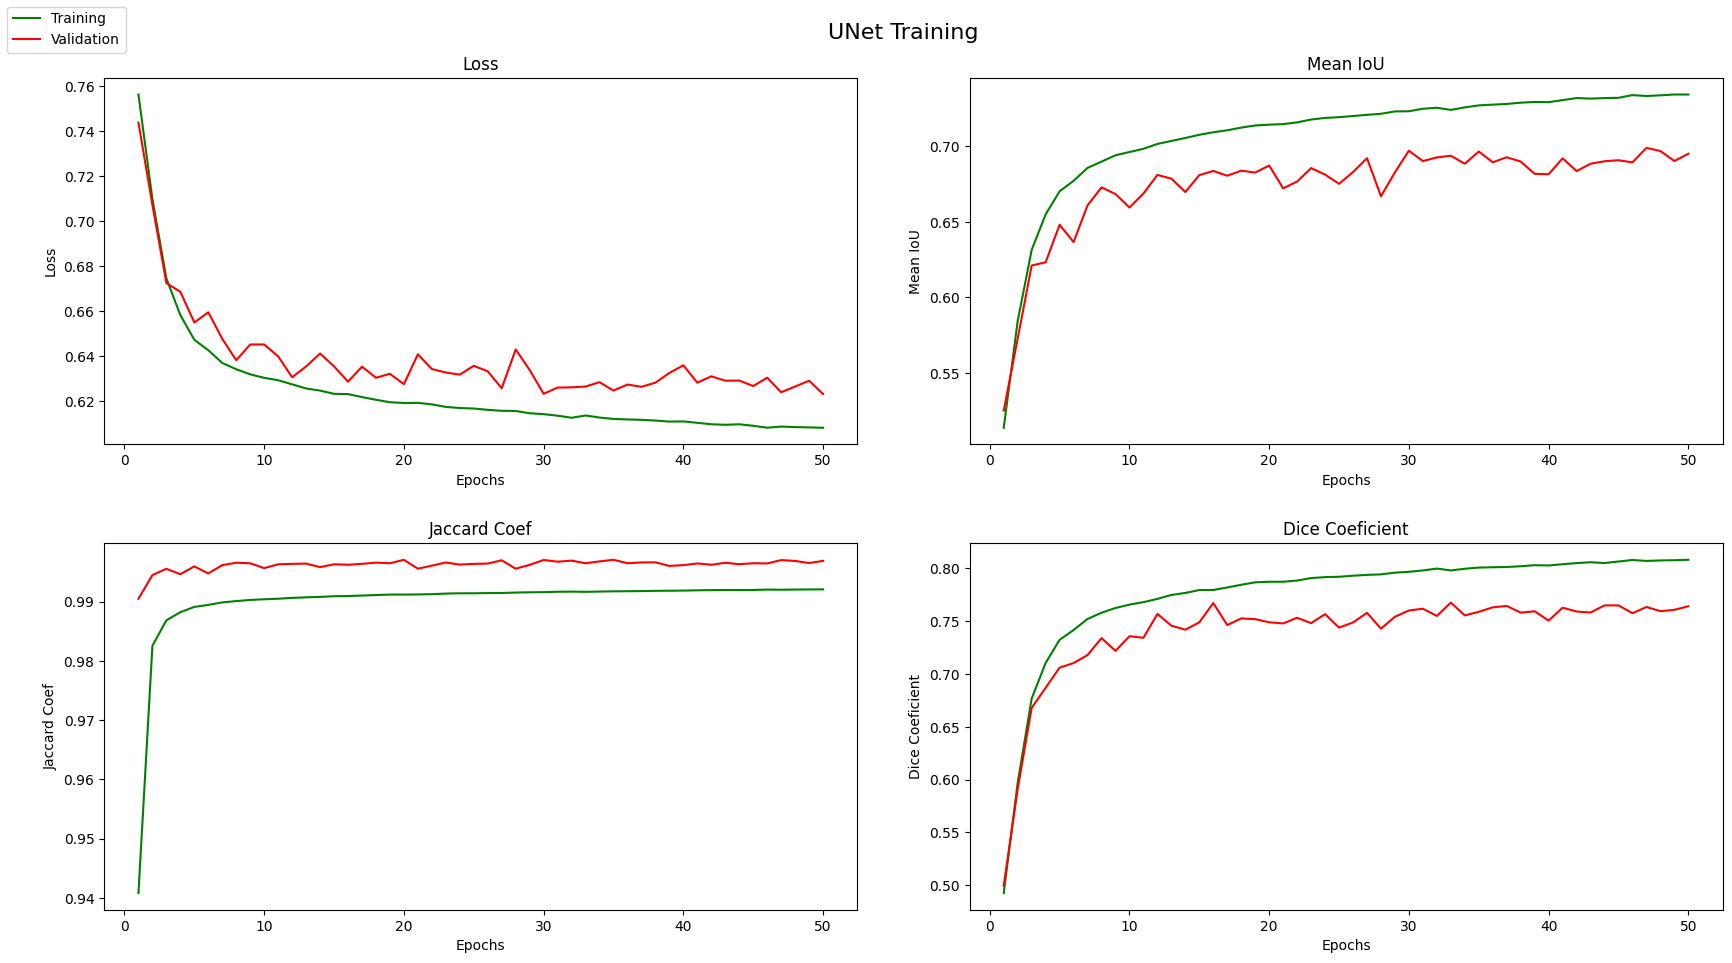

Model's last epoch's metrics:
loss = 0.6082
IOU score = 0.7224
Mean IOU = 0.7342
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8082
val_loss = 0.6232
val_IOU score = 0.6814
val_Mean IOU = 0.6951
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7642


In [16]:
# Plot Unet Training History
model_name = "Baseline_Unet_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "UNet Training")



In [40]:
# Train using UNET Resnet101 from segmentation_models package

model = sm.Unet('resnet101', encoder_weights='imagenet', classes=total_classes, activation='softmax')


model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Resnet101_Ash_Image_50_epochs"


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
   

641/641 [==============================] - 768s 1s/step - loss: 0.7157 - IOU score: 0.4981 - Mean IOU: 0.5381 - accuracy: 0.9814 - jaccard_coef: 0.9105 - Dice Coeficient: 0.5557 - val_loss: 0.7651 - val_IOU score: 0.4993 - val_Mean IOU: 0.4995 - val_accuracy: 0.9982 - val_jaccard_coef: 0.9962 - val_Dice Coeficient: 0.4999
Epoch 2/50
641/641 [==============================] - 712s 1s/step - loss: 0.6403 - IOU score: 0.6613 - Mean IOU: 0.6805 - accuracy: 0.9952 - jaccard_coef: 0.9897 - Dice Coeficient: 0.7449 - val_loss: 0.6596 - val_IOU score: 0.6032 - val_Mean IOU: 0.6397 - val_accuracy: 0.9985 - val_jaccard_coef: 0.9968 - val_Dice Coeficient: 0.6661
Epoch 3/50
641/641 [==============================] - 710s 1s/step - loss: 0.6299 - IOU score: 0.6787 - Mean IOU: 0.6960 - accuracy: 0.9955 - jaccard_coef: 0.9904 - Dice Coeficient: 0.7640 - val_loss: 0.6489 - val_IOU score: 0.6310 - val_Mean IOU: 0.6569 - val_accuracy: 0.9984 - val_jaccard_coef: 0.9965 - val_Dice Coeficient: 0.7045
Epoch 

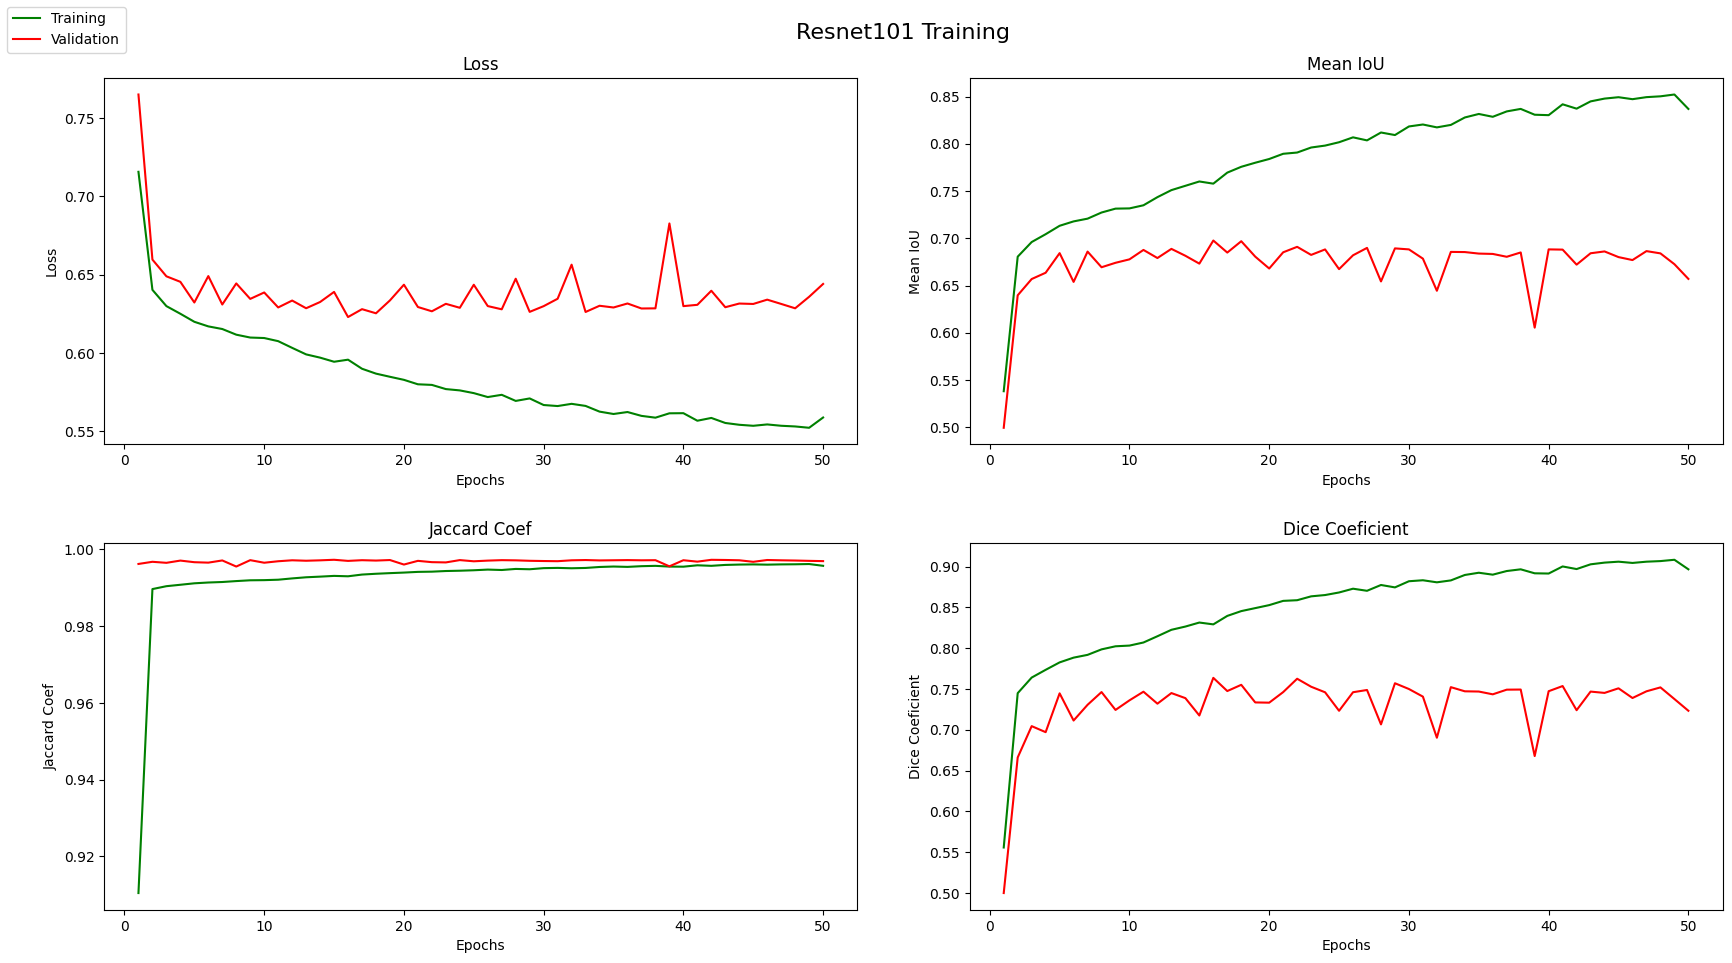

Model's last epoch's metrics:
loss = 0.5587
IOU score = 0.8288
Mean IOU = 0.8369
accuracy = 0.9980
jaccard_coef = 0.9957
Dice Coeficient = 0.8967
val_loss = 0.6440
val_IOU score = 0.6458
val_Mean IOU = 0.6570
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7233


In [15]:
# Plot Resnet101 Training History
model_name = "Baseline_Resnet101_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Resnet101 Training")

In [ ]:
# Train DeeplabV3+ with Resnet50

BATCH_SIZE = 16
training_generator = DataGenerator(train_id_list, image_channels=3, batch_size=BATCH_SIZE, kaggle=False)
# test_generator = DataGenerator(test_id_list, image_channels=3, batch_size=1, shuffle=False, test=True, kaggle=True)
validation_generator = DataGenerator(validation_id_list, image_channels=3, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False)


input_shape = (256, 256, 3)
model = DeepLabV3Plus(input_shape)

model.compile(optimizer="adam", 
              loss=bce_dice_loss, 
              metrics=metrics)

model_name = "Baseline_DeepLabv3Plus_Ash_Image_50_epochs_BCE_Dice_Loss"


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
   

Epoch 1/50


2023-07-12 02:07:43.802862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900
2023-07-12 02:07:53.887326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f77123d8fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-12 02:07:53.887391: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-12 02:07:54.765831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-12 02:07:57.032078: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1283/1283 [==============================] - 739s 526ms/step - loss: 0.0290 - IOU score: 0.5252 - Mean IOU: 0.5589 - accuracy: 0.9941 - jaccard_coef: 0.9874 - Dice Coeficient: 0.5507 - val_loss: 0.0085 - val_IOU score: 0.5181 - val_Mean IOU: 0.5603 - val_accuracy: 0.9983 - val_jaccard_coef: 0.9966 - val_Dice Coeficient: 0.5337
Epoch 2/50
1283/1283 [==============================] - 676s 525ms/step - loss: 0.0185 - IOU score: 0.5639 - Mean IOU: 0.6283 - accuracy: 0.9955 - jaccard_coef: 0.9903 - Dice Coeficient: 0.6140 - val_loss: 0.0420 - val_IOU score: 0.5325 - val_Mean IOU: 0.6097 - val_accuracy: 0.9984 - val_jaccard_coef: 0.9831 - val_Dice Coeficient: 0.5706
Epoch 3/50
1283/1283 [==============================] - 675s 525ms/step - loss: 0.0173 - IOU score: 0.5788 - Mean IOU: 0.6472 - accuracy: 0.9957 - jaccard_coef: 0.9907 - Dice Coeficient: 0.6366 - val_loss: 0.0083 - val_IOU score: 0.5323 - val_Mean IOU: 0.5801 - val_accuracy: 0.9984 - val_jaccard_coef: 0.9968 - val_Dice Coeficient

In [10]:
print('completed')

completed


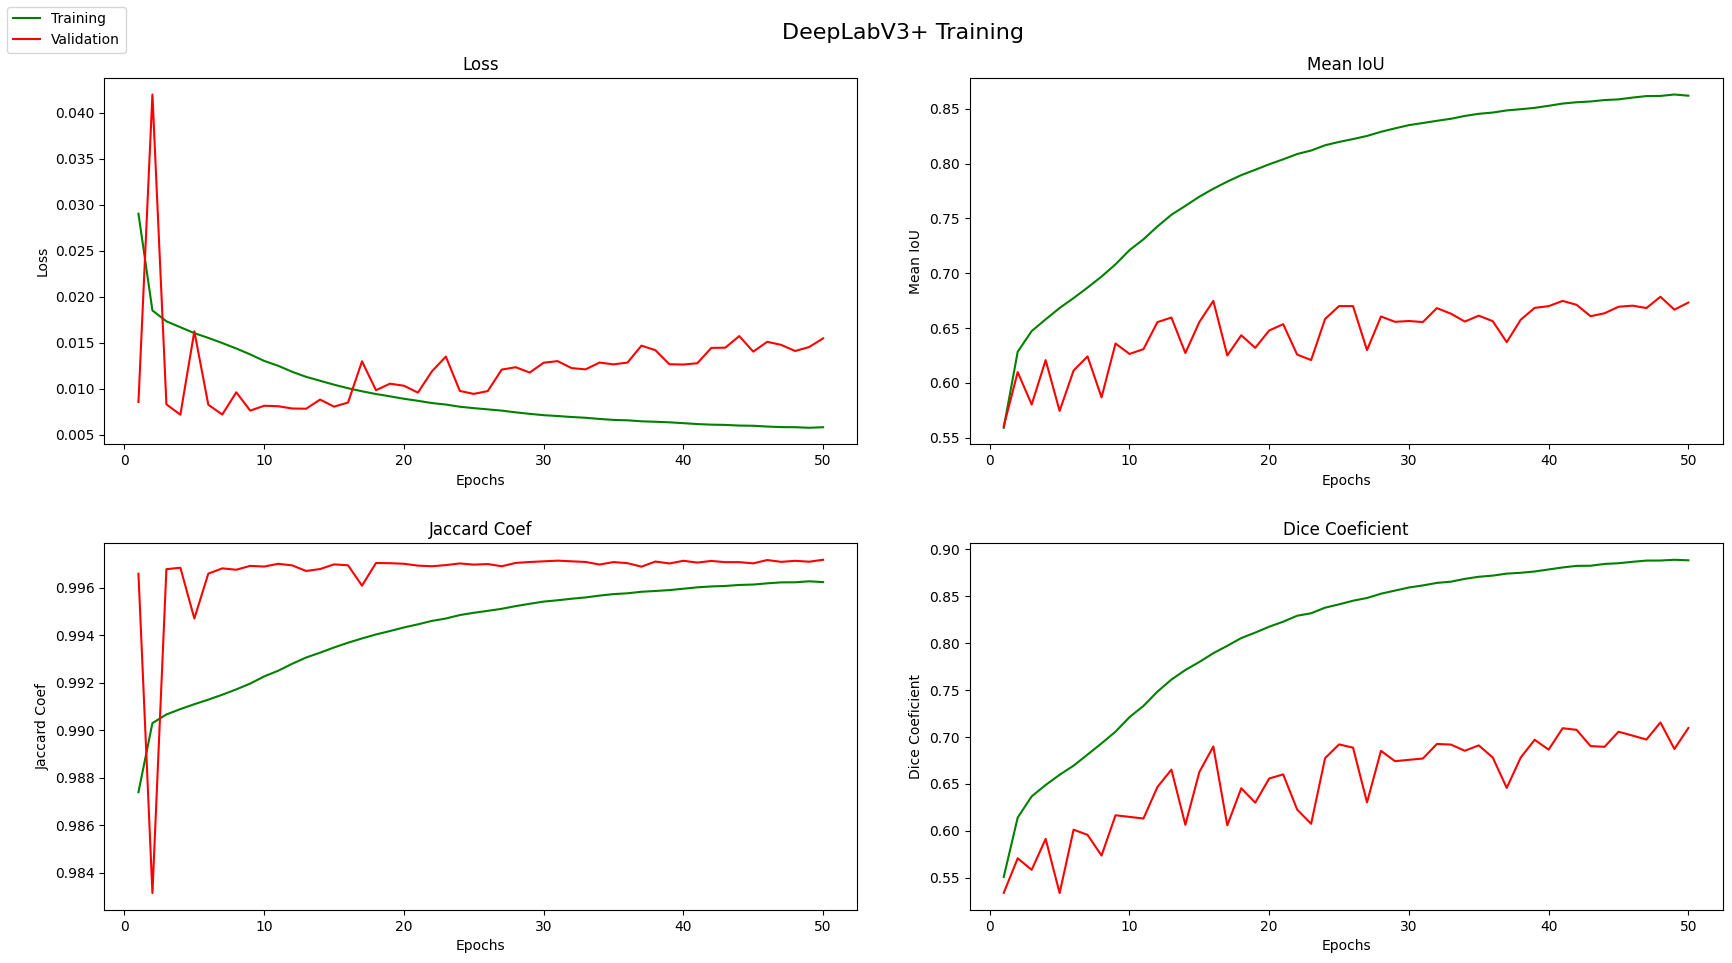

Model's last epoch's metrics:
loss = 0.006
IOU score = 0.818
Mean IOU = 0.862
accuracy = 0.998
jaccard_coef = 0.996
Dice Coeficient = 0.888
val_loss = 0.015
val_IOU score = 0.639
val_Mean IOU = 0.673
val_accuracy = 0.999
val_jaccard_coef = 0.997
val_Dice Coeficient = 0.710


In [11]:
# Plot DeeplabV3+ Training History
model_name = "Baseline_DeepLabv3Plus_Ash_Image_50_epochs_BCE_Dice_Loss"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "DeepLabV3+ Training")

In [21]:
# Train UNet using all time-series images 
BATCH_SIZE = 32
IMAGE_CHANNELS = 9
# Loaders need to use 24 channels (RGB X 8 time-series images)
training_generator = DataGenerator(train_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, kaggle=False, time_series=True)
# test_generator = DataGenerator(test_id_list, image_channels=24, batch_size=1, shuffle=False, test=True, kaggle=True, time_series=True)
validation_generator = DataGenerator(validation_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False, time_series=True)

# Train Unet Model 
model = multi_unet_model(image_channels=IMAGE_CHANNELS)

model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Unet_time_series_Ash_Image_50_epochs"


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

Epoch 1/50


2023-07-12 18:11:55.109955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 623s 925ms/step - loss: 0.7471 - IOU score: 0.4865 - Mean IOU: 0.5375 - accuracy: 0.9919 - jaccard_coef: 0.9542 - Dice Coeficient: 0.5080 - val_loss: 0.7411 - val_IOU score: 0.5182 - val_Mean IOU: 0.5281 - val_accuracy: 0.9935 - val_jaccard_coef: 0.9828 - val_Dice Coeficient: 0.5421
Epoch 2/50
641/641 [==============================] - 601s 933ms/step - loss: 0.7059 - IOU score: 0.5597 - Mean IOU: 0.5901 - accuracy: 0.9926 - jaccard_coef: 0.9835 - Dice Coeficient: 0.6097 - val_loss: 0.7097 - val_IOU score: 0.5561 - val_Mean IOU: 0.5751 - val_accuracy: 0.9971 - val_jaccard_coef: 0.9929 - val_Dice Coeficient: 0.5995
Epoch 3/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6778 - IOU score: 0.6031 - Mean IOU: 0.6277 - accuracy: 0.9938 - jaccard_coef: 0.9867 - Dice Coeficient: 0.6721 - val_loss: 0.6846 - val_IOU score: 0.5889 - val_Mean IOU: 0.6044 - val_accuracy: 0.9977 - val_jaccard_coef: 0.9950 - val_Dice Coeficient: 0.64

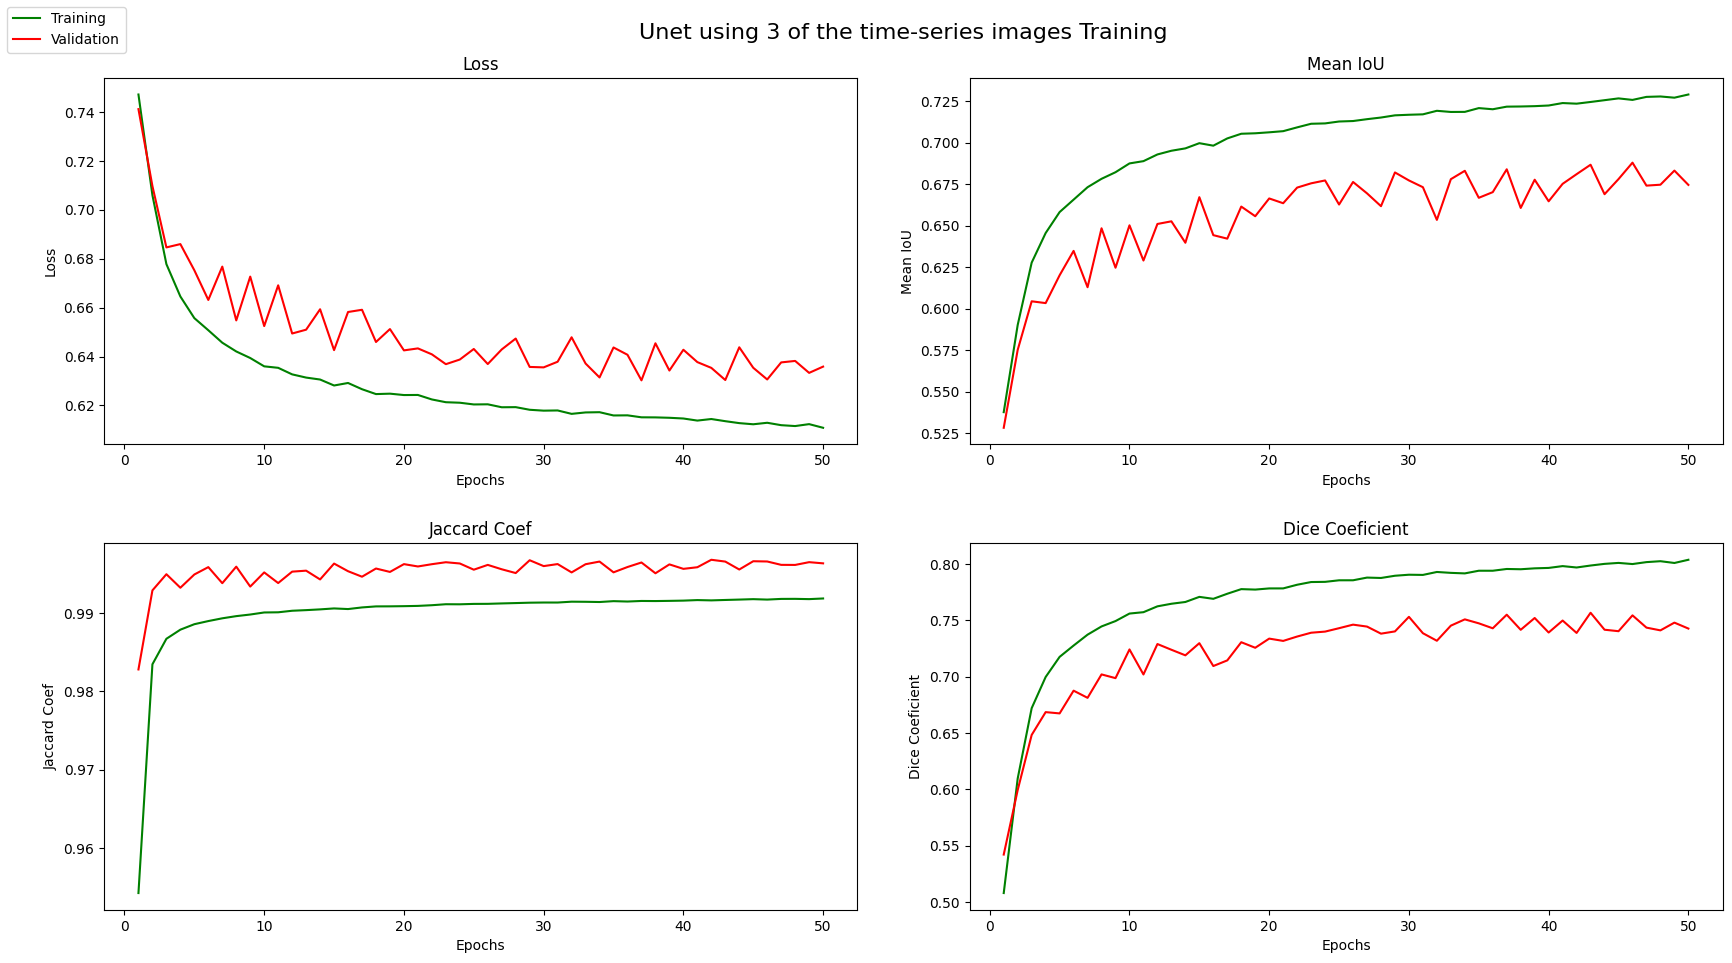

Model's last epoch's metrics:
loss = 0.6109
IOU score = 0.7179
Mean IOU = 0.7291
accuracy = 0.9961
jaccard_coef = 0.9919
Dice Coeficient = 0.8039
val_loss = 0.6359
val_IOU score = 0.6625
val_Mean IOU = 0.6746
val_accuracy = 0.9982
val_jaccard_coef = 0.9964
val_Dice Coeficient = 0.7428


In [22]:
# Plot Training History with Unet using 3 of the time-series images 
model_name = "Baseline_Unet_time_series_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Unet using 3 of the time-series images Training")

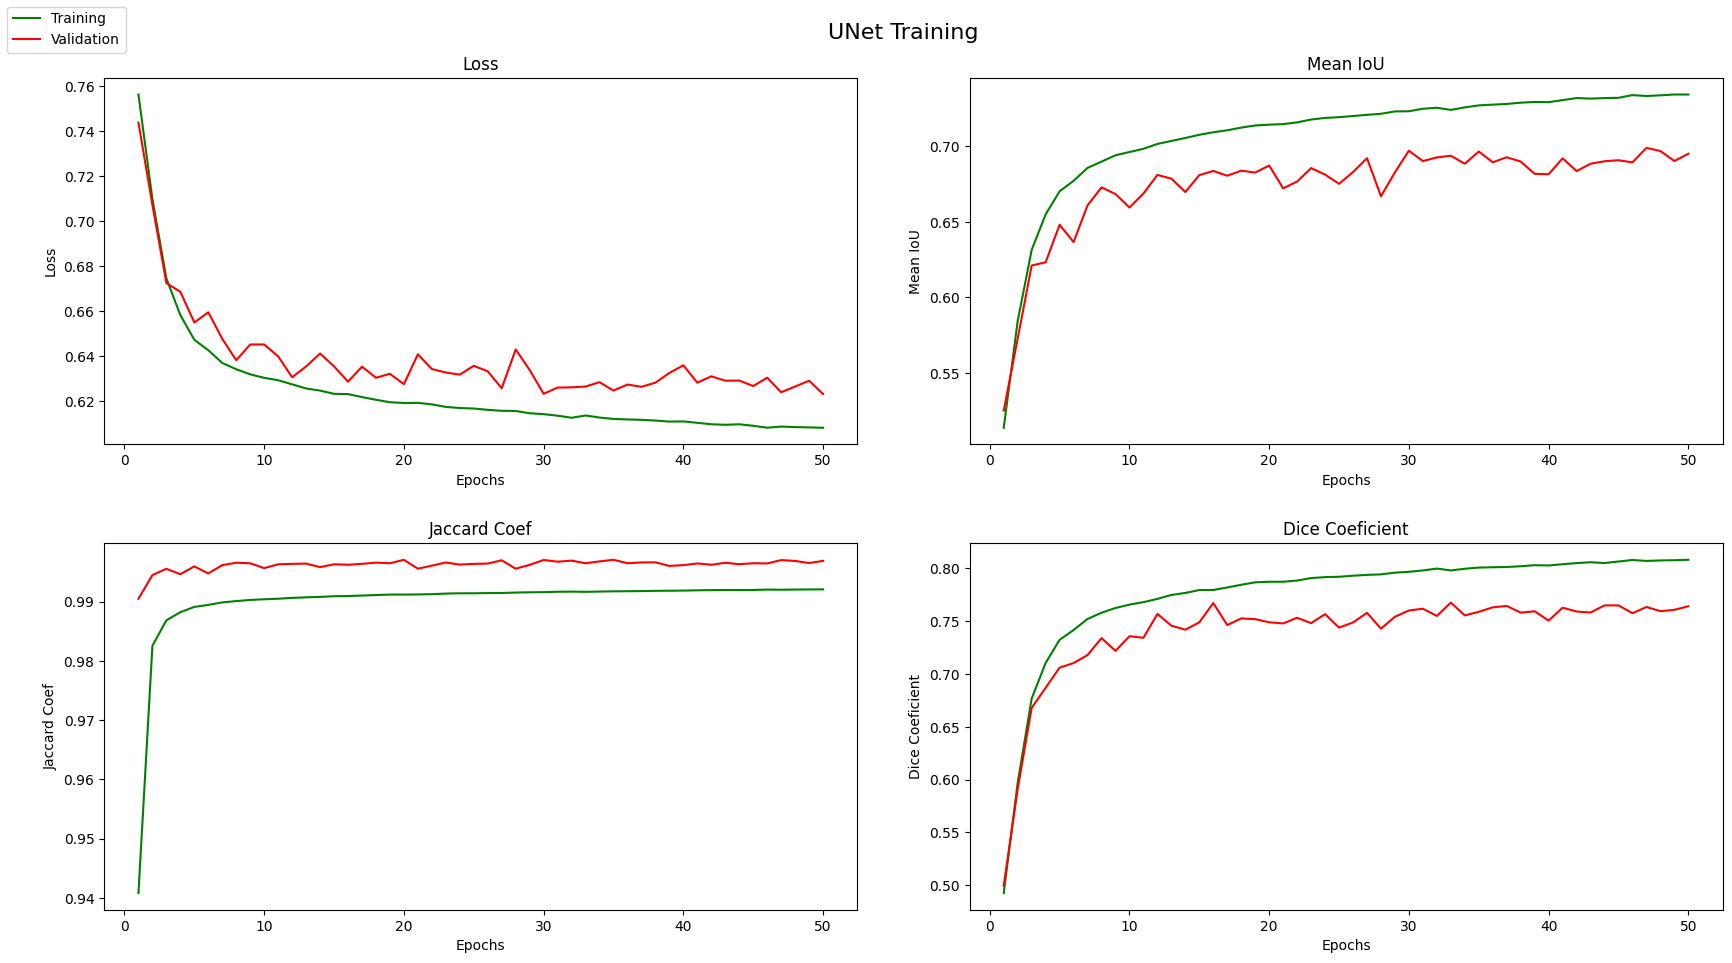

Model's last epoch's metrics:
loss = 0.6082
IOU score = 0.7224
Mean IOU = 0.7342
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8082
val_loss = 0.6232
val_IOU score = 0.6814
val_Mean IOU = 0.6951
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7642


In [17]:
# Plot Unet Training History
model_name = "Baseline_Unet_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "UNet Training")

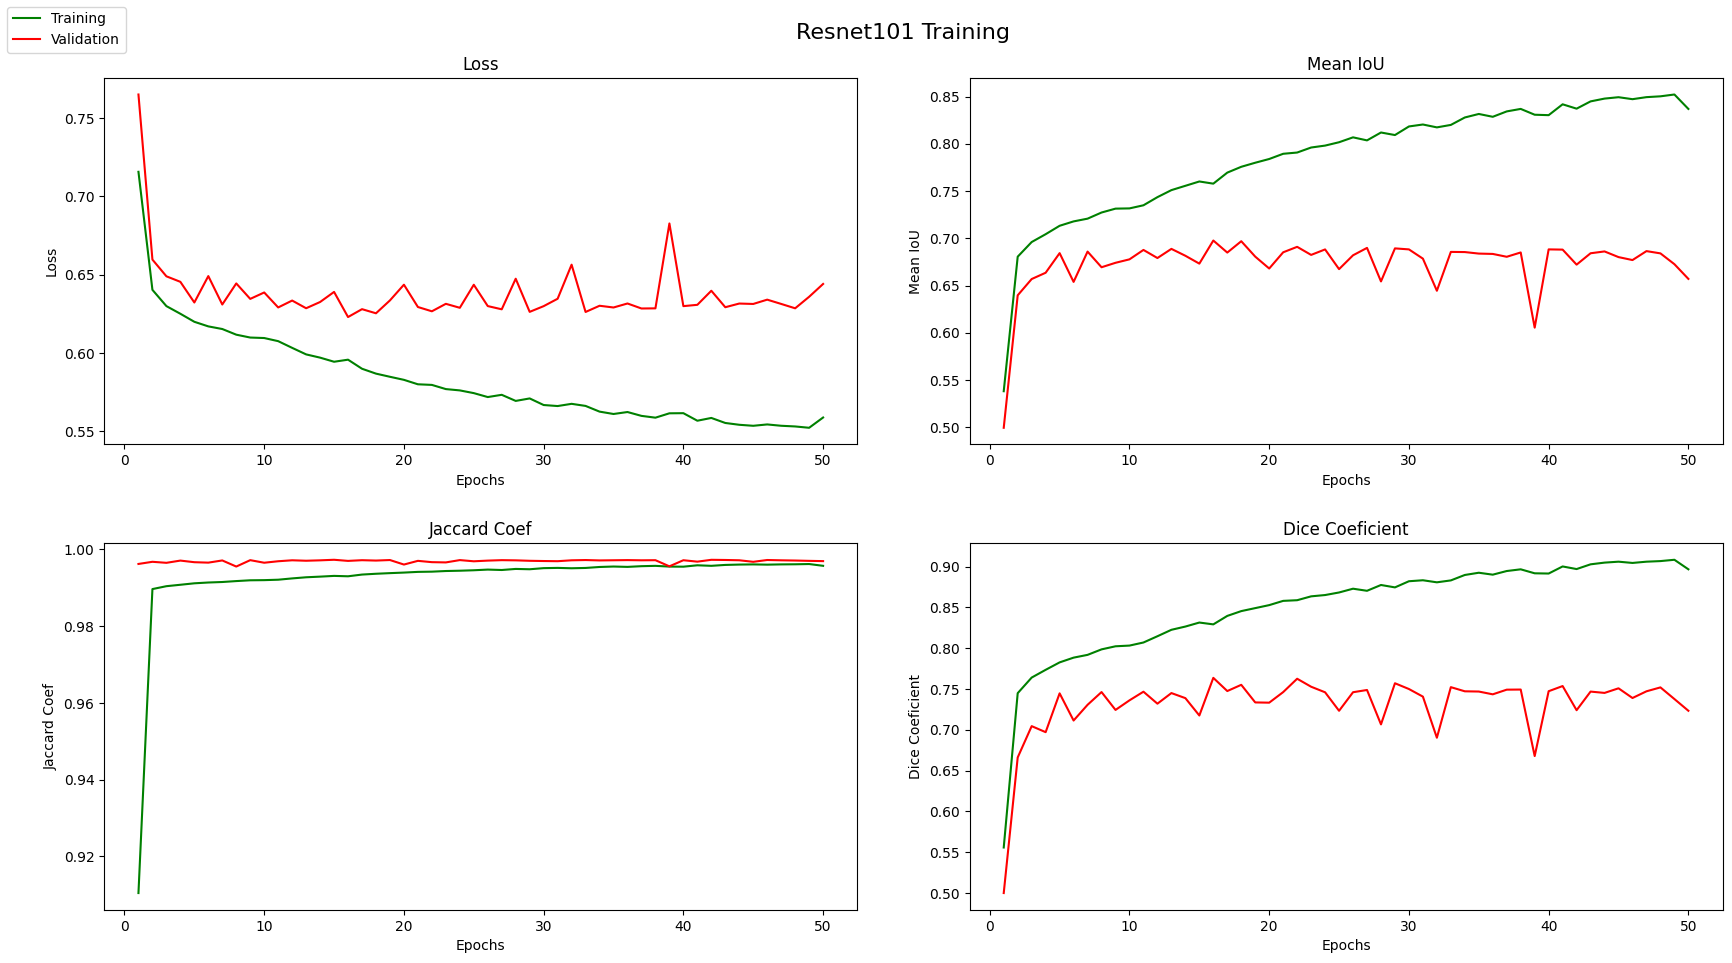

Model's last epoch's metrics:
loss = 0.5587
IOU score = 0.8288
Mean IOU = 0.8369
accuracy = 0.9980
jaccard_coef = 0.9957
Dice Coeficient = 0.8967
val_loss = 0.6440
val_IOU score = 0.6458
val_Mean IOU = 0.6570
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7233


In [19]:
# Plot Resnet101 Training History
model_name = "Baseline_Resnet101_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Resnet101 Training")

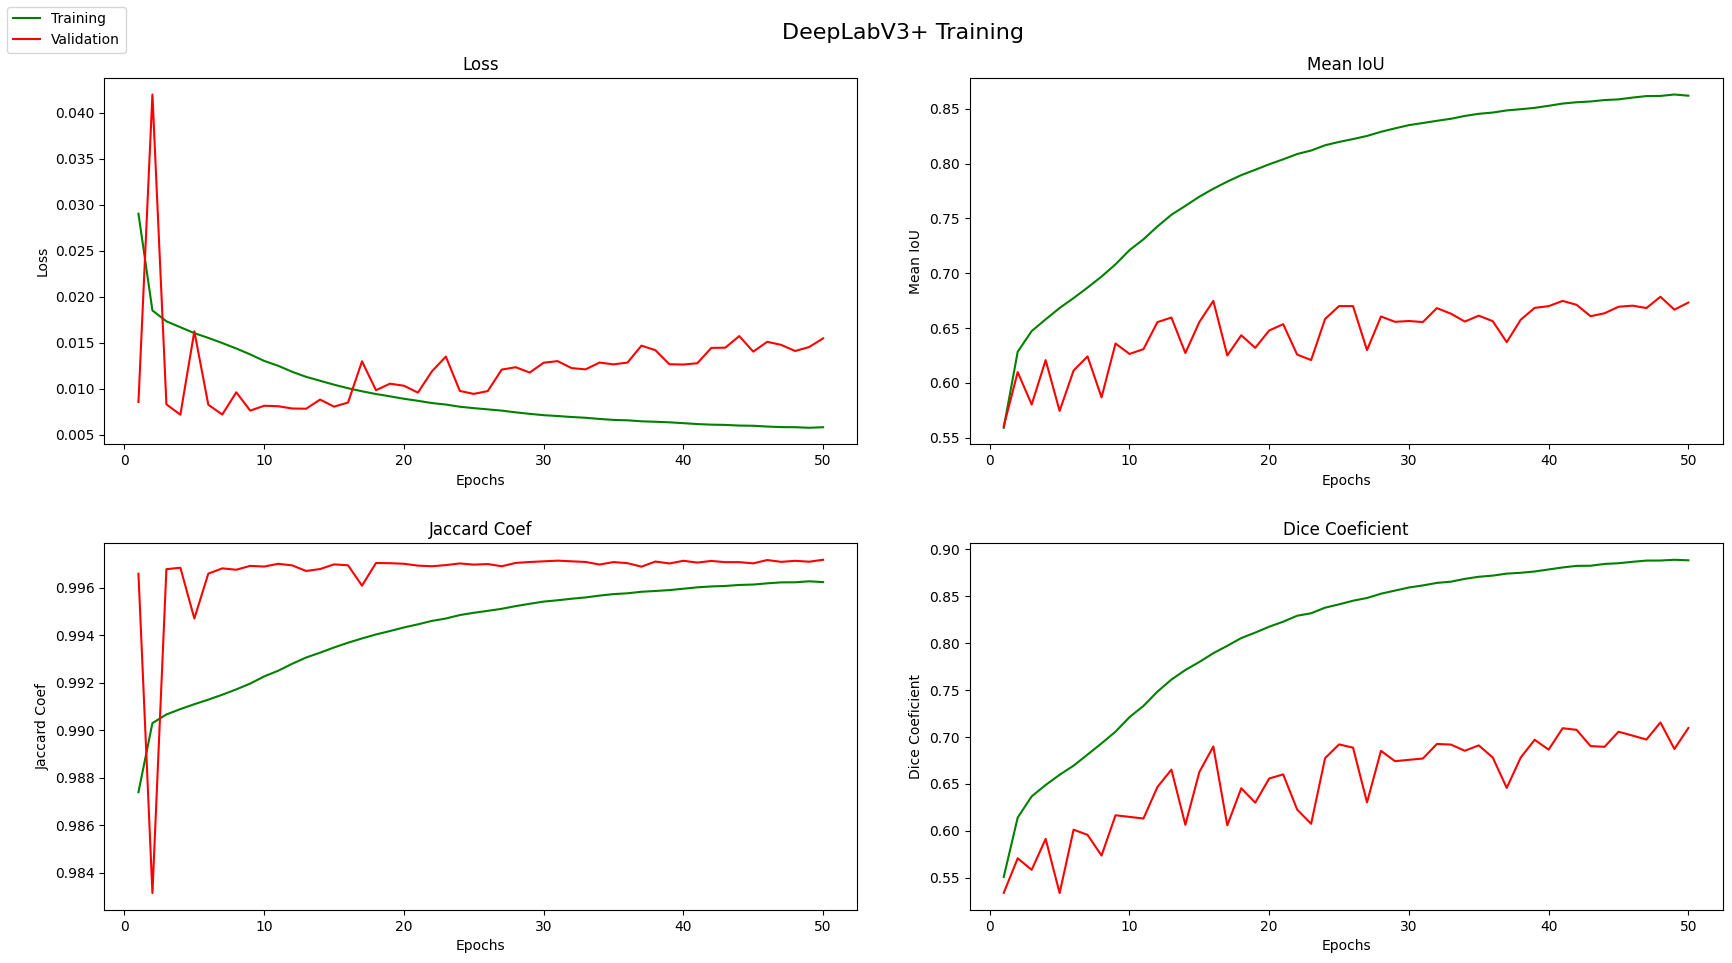

Model's last epoch's metrics:
loss = 0.0058
IOU score = 0.8182
Mean IOU = 0.8620
accuracy = 0.9983
jaccard_coef = 0.9962
Dice Coeficient = 0.8884
val_loss = 0.0155
val_IOU score = 0.6391
val_Mean IOU = 0.6732
val_accuracy = 0.9986
val_jaccard_coef = 0.9972
val_Dice Coeficient = 0.7095


In [20]:
# Plot DeeplabV3+ Training History
model_name = "Baseline_DeepLabv3Plus_Ash_Image_50_epochs_BCE_Dice_Loss"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "DeepLabV3+ Training")


# TransUnet with different Learning rate

In [ ]:
# TransUnet model training with exponential decay learning rate
NUM_EPOCHS = 50
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    name="Adam")

model = trans_unet_model()

model.compile(optimizer=optimizer, 
              loss=total_loss, 
              metrics=metrics)

model_name = "Trans_Unet_w_lr_decay_50_epochs"

train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
  

Epoch 1/50


2023-07-13 03:41:31.281984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 714s 924ms/step - loss: 0.7525 - IOU score: 0.4852 - Mean IOU: 0.5276 - accuracy: 0.9930 - jaccard_coef: 0.9438 - Dice Coeficient: 0.5047 - val_loss: 0.7310 - val_IOU score: 0.5168 - val_Mean IOU: 0.5419 - val_accuracy: 0.9979 - val_jaccard_coef: 0.9945 - val_Dice Coeficient: 0.5330
Epoch 2/50
641/641 [==============================] - 602s 935ms/step - loss: 0.6883 - IOU score: 0.5893 - Mean IOU: 0.6133 - accuracy: 0.9936 - jaccard_coef: 0.9860 - Dice Coeficient: 0.6527 - val_loss: 0.6864 - val_IOU score: 0.5825 - val_Mean IOU: 0.6020 - val_accuracy: 0.9977 - val_jaccard_coef: 0.9948 - val_Dice Coeficient: 0.6404
Epoch 3/50
641/641 [==============================] - 602s 935ms/step - loss: 0.6627 - IOU score: 0.6277 - Mean IOU: 0.6490 - accuracy: 0.9945 - jaccard_coef: 0.9882 - Dice Coeficient: 0.7044 - val_loss: 0.6687 - val_IOU score: 0.6118 - val_Mean IOU: 0.6274 - val_accuracy: 0.9979 - val_jaccard_coef: 0.9954 - val_Dice Coeficient: 0.68

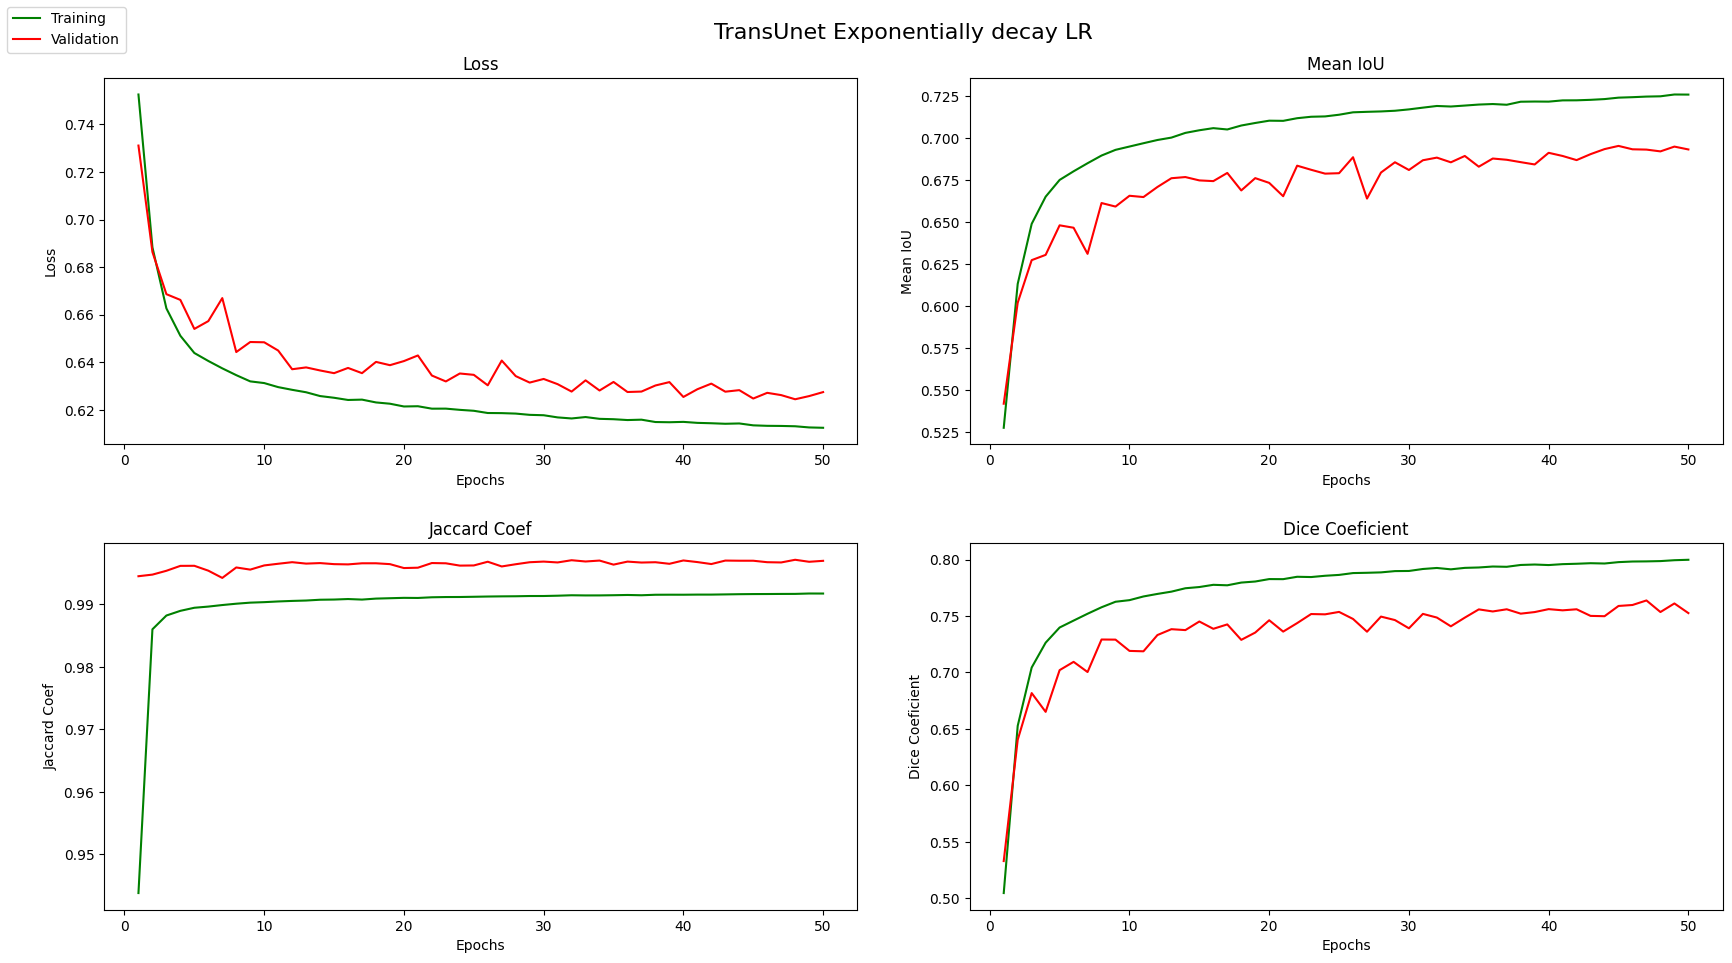

Model's last epoch's metrics:
loss = 0.6126
IOU score = 0.7138
Mean IOU = 0.7260
accuracy = 0.9960
jaccard_coef = 0.9917
Dice Coeficient = 0.7998
val_loss = 0.6275
val_IOU score = 0.6710
val_Mean IOU = 0.6933
val_accuracy = 0.9986
val_jaccard_coef = 0.9970
val_Dice Coeficient = 0.7526


In [35]:
# Plot DeeplabV3+ Training History
model_name = "Trans_Unet_w_lr_decay_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "TransUnet Exponentially decay LR")

In [33]:
print('completed')

completed
